# Lesson 6. Spatial Queries

In spatial analysis, our goal is not just to make nice maps,
but to actually run analyses that leverage the explicitly spatial
nature of our data. The process of doing this is known as 
**spatial analysis**.

To construct spatial analyses, we string together series of spatial
operations in such a way that the end result answers our question of interest.
There are many such spatial operations. We will start by reviewing the most
fundamental set, which we'll refer to as **spatial queries**.
These can be divided into:

- <u>Measurement queries</u>
    - What is feature A's **length**?
    - What is feature A's **area**?
    - What is feature A's **perimeter**?
    - What is feature A's **distance** from feature B?
    - etc.
- <u>Relationship queries</u>
    - Is feature A **within** feature B?
    - Does feature A **intersect** with feature B?
    - Does feature A **cross** feature B?
    - etc.
    
We'll work through examples of each of those types of queries.

Then we'll see an example of a very common spatial analysis that 
is a conceptual amalgam of those two types: **proximity analysis**.


In [2]:
import pandas as pd
import geopandas as gpd

import matplotlib # base python plotting library
import matplotlib.pyplot as plt # submodule of matplotlib

# To display plots, maps, charts etc in the notebook
%matplotlib inline  

# 6.0 Load and prep some data

Let's read in our census tracts data again.

<AxesSubplot:>

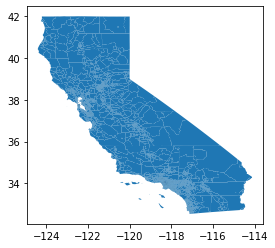

In [3]:
census_tracts = gpd.read_file("zip://notebook_data/census/Tracts/cb_2013_06_tract_500k.zip")
census_tracts.plot()

In [4]:
census_tracts.head()

,STATEFP,COUNTYFP,TRACTCE,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,geometry
0,06,001,400300,1400000US06001400300,06001400300,4003,CT,1105329,0,"POLYGON ((-122.26416 37.84000, -122.26186 37.8..."
1,06,001,400900,1400000US06001400900,06001400900,4009,CT,420877,0,"POLYGON ((-122.28558 37.83978, -122.28319 37.8..."
2,06,001,402200,1400000US06001402200,06001402200,4022,CT,712082,0,"POLYGON ((-122.30403 37.80739, -122.30239 37.8..."
3,06,001,402800,1400000US06001402800,06001402800,4028,CT,398311,0,"POLYGON ((-122.27598 37.80622, -122.27335 37.8..."
4,06,001,404800,1400000US06001404800,06001404800,4048,CT,628405,0,"POLYGON ((-122.21825 37.80086, -122.21582 37.8..."


Then we'll grab just the Alameda Country tracts.

<AxesSubplot:>

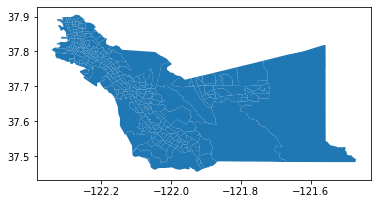

In [5]:
census_tracts_ac = census_tracts.loc[census_tracts['COUNTYFP']=='001']
census_tracts_ac.plot()

# 6.1 Measurement Queries

We'll start off with some simple measurement queries.

For example, here's how we can get the areas of each of our census tracts.

In [7]:
census_tracts_ac.area

0       0.000113
1       0.000045
2       0.000071
3       0.000041
4       0.000063
          ...   
7826    0.000098
7827    0.002275
7850    0.000033
8031    0.000139
8032    0.000316
Length: 361, dtype: float64

Okay! 

We got... 

numbers!

...?

<div style="display:inline-block;vertical-align:top;">
    <img src="http://www.pngall.com/wp-content/uploads/2016/03/Light-Bulb-Free-PNG-Image.png" width="30" align=left > 
</div>  
<div style="display:inline-block;">

#### Questions
</div>

1. What do those numbers mean?
1. What are our units?
1. And if we're not sure, how might be find out?

Let's take a look at our CRS.

In [11]:
census_tracts_ac.crs

{'init': 'epsg:4269'}

Ah-hah! We're working in an unprojected CRS, with units of decimal degrees.

**When doing spatial analysis, we will almost always want to work in a projected CRS
that has natural distance units, such as meters!**

Time to project!

(As previously, we'll use UTM Zone 10N with a NAD83 data.
This is a good choice for our region of interest.)

In [12]:
census_tracts_ac_utm10 = census_tracts_ac.to_crs( "epsg:26910")

/usr/lib/python3.8/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [13]:
census_tracts_ac_utm10.crs

'epsg:26910'

Now let's try our area calculation again.

In [14]:
census_tracts_ac_utm10.area

0       1.105797e+06
1       4.355184e+05
2       6.930523e+05
3       4.003615e+05
4       6.183936e+05
            ...     
7826    9.653980e+05
7827    2.230584e+07
7850    3.197167e+05
8031    1.355161e+06
8032    3.087534e+06
Length: 361, dtype: float64

That looks much more reasonable!

<div style="display:inline-block;vertical-align:top;">
    <img src="http://www.pngall.com/wp-content/uploads/2016/03/Light-Bulb-Free-PNG-Image.png" width="30" align=left > 
</div>  
<div style="display:inline-block;">

#### Question
</div>

What are our units now?


You may have noticed that our census tracts already have an area column in them.

Let's do a sanity check on our results.

In [15]:
# calculate the area for the 0th feature
census_tracts_ac_utm10.area[0]

1105796.6056939538

In [16]:
# get the area for the 0th feature according to its 'ALAND' attribute
census_tracts['ALAND'][0]

1105329

In [28]:
# check equivalence of the calculated areas and the 'ALAND' column
census_tracts_ac_utm10['ALAND'].values == census_tracts_ac_utm10.area

0       False
1       False
2       False
3       False
4       False
        ...  
7826    False
7827    False
7850    False
8031    False
8032    False
Length: 361, dtype: bool

<div style="display:inline-block;vertical-align:top;">
    <img src="http://www.pngall.com/wp-content/uploads/2016/03/Light-Bulb-Free-PNG-Image.png" width="30" align=left > 
</div>  
<div style="display:inline-block;">

#### Question
</div>

What explains this disagreement? Are the calculated areas incorrect?


# TODO: <font color='red'> WHY SUMMING THE AREAS HERE? </font>

In [29]:
census_tracts_ac_utm10.area.sum()

1948917581.1122904

As it turns out, we can similarly use another attribute
to get the features' lengths.

**NOTE**: In this case, given we're
dealing with polygons, this is equivalent to getting the features' perimeters.

In [27]:
census_tracts_ac_utm10.length

0        5357.060239
1        2756.937555
2        5395.895162
3        2681.974829
4        3710.388859
            ...     
7826     4331.600289
7827    32004.773556
7850     2353.624225
8031     4718.701537
8032     8176.643793
Length: 361, dtype: float64

In [ ]:










###########################################################
###########################################################
###########################################################

In [62]:
bart_df = pd.read_csv('notebook_data/transportation/bart.csv')
bart_df.head()

,lon,lat,STATION,OPERATOR,COUNTY
0,-122.283348,37.874061,NORTH BERKELEY,BART,ALA
1,-122.268250,37.869689,DOWNTOWN BERKELEY,BART,ALA
2,-122.270119,37.853207,ASHBY,BART,ALA
3,-122.251777,37.844510,ROCKRIDGE,BART,ALA
4,-122.267120,37.828705,MACARTHUR,BART,ALA


In [63]:
bart_gdf = gpd.GeoDataFrame(bart_df, 
                            geometry=gpd.points_from_xy(bart_df.lon, bart_df.lat))
bart_gdf.crs = "epsg:4326"

In [64]:
bart_gdf_utm10 = bart_gdf.to_crs( "epsg:26910")

In [38]:
schools_df = pd.read_csv('notebook_data/alco_schools.csv')
schools_df.head()

,X,Y,Site,Address,City,State,Type,API,Org
0,-122.238761,37.744764,Amelia Earhart Elementary,400 Packet Landing Rd,Alameda,CA,ES,933,Public
1,-122.251856,37.738999,Bay Farm Elementary,200 Aughinbaugh Way,Alameda,CA,ES,932,Public
2,-122.258915,37.762058,Donald D. Lum Elementary,1801 Sandcreek Way,Alameda,CA,ES,853,Public
3,-122.234841,37.765250,Edison Elementary,2700 Buena Vista Ave,Alameda,CA,ES,927,Public
4,-122.238078,37.753964,Frank Otis Elementary,3010 Fillmore St,Alameda,CA,ES,894,Public


In [39]:
schools_gdf = gpd.GeoDataFrame(schools_df, 
                               geometry=gpd.points_from_xy(schools_df.X, schools_df.Y))
schools_gdf.crs = "epsg:4326"

In [40]:
schools_gdf_utm10 = schools_gdf.to_crs( "epsg:26910")

In [73]:
schools_gdf_utm10.apply(lambda row: row['geometry'].distance(bart_gdf_utm10[bart_gdf_utm10.STATION == 'DOWNTOWN BERKELEY', :]))

KeyError: ('geometry', 'occurred at index X')

In [ ]:
###########################################################
###########################################################
###########################################################









# 6.2 Relationship Queries


[Spatial relationship queries](https://en.wikipedia.org/wiki/Spatial_relation) consider how two geometries or sets of geometries relate to one another in space. 

<img src="https://upload.wikimedia.org/wikipedia/commons/5/55/TopologicSpatialRelarions2.png" height="300px"></img>


Here is a list of the most commonly used GeoPandas methods to test spatial relationships.

- [within](http://geopandas.org/reference.html?highlight=distance#geopandas.GeoSeries.within)
- [contains](http://geopandas.org/reference.html?highlight=distance#geopandas.GeoSeries.contains) (the inverse of `within`)
- [intersects](http://geopandas.org/reference.html?highlight=distance#geopandas.GeoSeries.intersects)

<br>
There several other GeoPandas spatial relationship predicates but they are more complex to properly employ. For example the following two operations only work with geometries that are completely aligned.

- [touches](http://geopandas.org/reference.html?highlight=distance#geopandas.GeoSeries.touches)
- [equals](http://geopandas.org/reference.html?highlight=distance#geopandas.GeoSeries.equals)


All of these methods takes the form:

    Geoseries.<predicate>(geometry)
    
For example:

    Geoseries.contains(geometry)

--------------------------------

Let's load our counties dataset to demonstrate these queries.

In [32]:
counties = gpd.read_file('notebook_data/california_counties/CaliforniaCounties.shp')
counties.head()

,FID_,NAME,STATE_NAME,POP2010,POP10_SQMI,POP2012,POP12_SQMI,WHITE,BLACK,AMERI_ES,...,AVG_SALE07,SQMI,CountyFIPS,NEIGHBORS,PopNeigh,NEIGHBOR_1,PopNeigh_1,NEIGHBOR_2,PopNeigh_2,geometry
0,0,Kern,California,839631,102.9,851089,104.282870,499766,48921,12676,...,1513.53,8161.35,06103,"San Bernardino,Tulare,Inyo",2495935,None,None,None,None,"POLYGON ((193446.035 -244342.585, 194033.795 -..."
1,0,Kings,California,152982,109.9,155039,111.427421,83027,11014,2562,...,1203.20,1391.39,06089,"Fresno,Kern,Tulare",2212260,None,None,None,None,"POLYGON ((12524.028 -179431.328, 12358.142 -17..."
2,0,Lake,California,64665,48.6,65253,49.082334,52033,1232,2049,...,72.31,1329.46,06106,None,0,None,None,None,None,"MULTIPOLYGON (((-240632.150 93056.104, -240669..."
3,0,Lassen,California,34895,7.4,35039,7.422856,25532,2834,1234,...,120.92,4720.42,06086,None,0,None,None,None,None,"POLYGON ((-45364.032 352060.633, -45248.844 35..."
4,0,Los Angeles,California,9818605,2402.3,9904341,2423.264150,4936599,856874,72828,...,187.94,4087.19,06073,"San Bernardino,Kern",2874841,None,None,None,None,"MULTIPOLYGON (((173874.519 -471855.293, 173852..."


<AxesSubplot:>

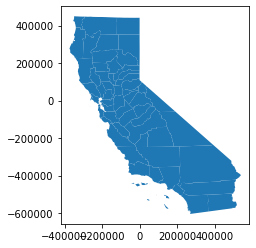

In [36]:
counties.plot()

We'll again reproject our data to UTM Zone 10N (EPSG: 26910).

In [33]:
counties_utm10 = counties.to_crs( "epsg:26910")

/usr/lib/python3.8/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


Then let's grab just Alameda County.

In [106]:
ac_utm10 = counties_utm10.loc[counties_utm10['NAME']=='Alameda']

<AxesSubplot:>

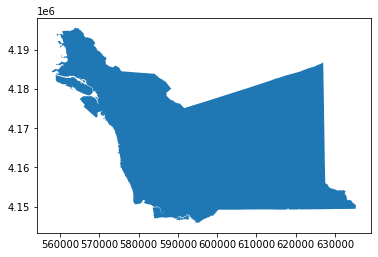

In [107]:
ac_utm10.plot()

Now let's also load a dataset containing all the protected areas (parks and the like) in California.

In [124]:
pas = gpd.read_file('./notebook_data/protected_areas/CPAD_2020a_Units.shp')

Does this need to be reprojected too?

In [104]:
pas.crs

{'init': 'epsg:3310'}

Yes it does!

Let's reproject it.

In [95]:
pas_utm10 = pas.to_crs("epsg:26910")

/usr/lib/python3.8/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


One common use for spatial queries is for spatial subsetting of data.

In our case, lets use **intersects** to
find all of the parks that have land in Alameda County.

In [186]:
pas_in_ac = pas_utm10.intersects(ac_utm10.geometry.squeeze())

If we scroll the resulting GeoDataFrame to the right we'll see that 
the 'COUNTY' column of our resulting subset gives us a good sanity check on our results.

In [187]:
pas_utm10[pas_in_ac].head()

,ACCESS_TYP,UNIT_ID,UNIT_NAME,SUID_NMA,AGNCY_ID,AGNCY_NAME,AGNCY_LEV,AGNCY_TYP,AGNCY_WEB,LAYER,...,MNG_AG_LEV,MNG_AG_TYP,PARK_URL,COUNTY,ACRES,LABEL_NAME,YR_EST,DES_TP,GAP_STS,geometry
63,Open Access,185,Augustin Bernal Park,8732,1257,"Pleasanton, City of",City,City Agency,http://www.cityofpleasantonca.gov/,City,...,City,City Agency,http://www.cityofpleasantonca.gov/services/rec...,Alameda,217.388,Augustin Bernal Park,0.0,Local Park,4,"POLYGON ((595746.574 4165882.573, 595740.013 4..."
145,Open Access,366,San Antonio Park,24832,1228,"Oakland, City of",City,City Agency,http://www2.oaklandnet.com/Government/o/opr/in...,City,...,City,City Agency,None,Alameda,10.619,San Antonio Park,0.0,Local Park,4,"POLYGON ((566704.422 4182789.292, 566827.750 4..."
217,Open Access,586,Quarry Lakes Regional Recreation Area,30594,2032,East Bay Regional Park District,Special District,Recreation/Parks District,http://www.ebparks.org/,Special District,...,Special District,Recreation/Parks District,None,Alameda,254.616,Quarry Lakes Reg. Rec. Area,2001.0,Local Recreation Area,4,"MULTIPOLYGON (((588060.979 4158338.499, 587843..."
393,Open Access,1438,Tennis & Community Park,26243,1257,"Pleasanton, City of",City,City Agency,http://www.cityofpleasantonca.gov/,City,...,City,City Agency,None,Alameda,15.595,Tennis & Community Park,0.0,Local Park,4,"POLYGON ((596761.389 4170334.335, 597109.868 4..."
408,Open Access,48353,Sean Diamond Park,32917,1090,"Dublin, City of",City,City Agency,http://www.ci.dublin.ca.us/index.aspx?nid=1458,City,...,City,City Agency,https://www.dublin.ca.gov/Facilities/Facility/...,Alameda,4.986,Sean Diamond Park,2018.0,Local Park,4,"POLYGON ((601693.284 4175288.100, 601695.836 4..."


So does this overlay plot!

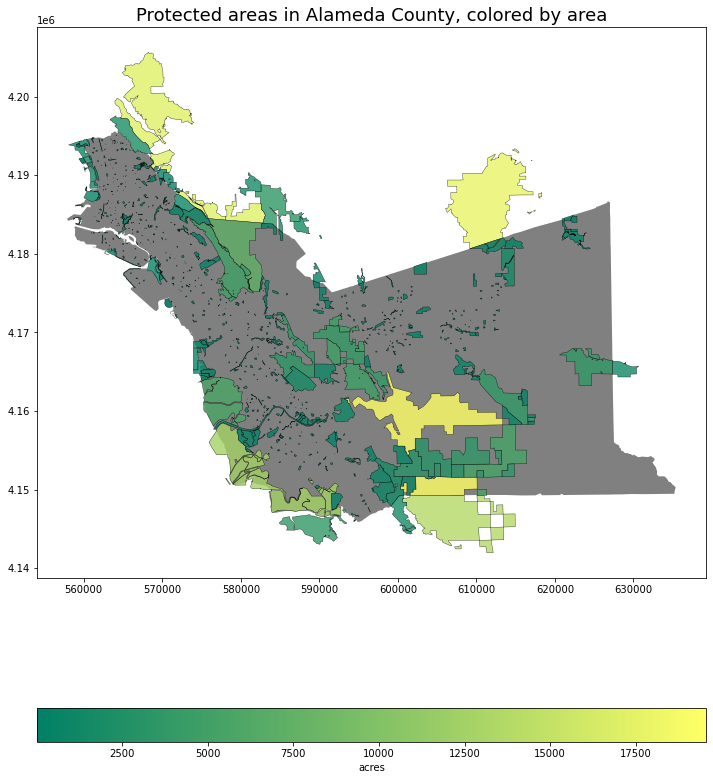

In [194]:
ax = ac_utm10.plot(color='gray', figsize=[12,16])
pas_utm10[pas_in_ac].plot(ax=ax, column='ACRES', cmap='summer', legend=True,
                          edgecolor='black', linewidth=0.4, alpha=0.8,
                          legend_kwds={'label': "acres",
                                       'orientation': "horizontal"})
ax.set_title('Protected areas in Alameda County, colored by area', size=18);

## Exercise(?)
What alameda county schools are in Berkeley?

In [230]:
berkeley = gpd.read_file("notebook_data/berkeley/BerkeleyCityLimits.shp")
berkeley_utm10 = berkeley.to_crs("epsg:26910")

/usr/lib/python3.8/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [202]:
schools_df = pd.read_csv('notebook_data/alco_schools.csv')
schools_df.head()

,X,Y,Site,Address,City,State,Type,API,Org
0,-122.238761,37.744764,Amelia Earhart Elementary,400 Packet Landing Rd,Alameda,CA,ES,933,Public
1,-122.251856,37.738999,Bay Farm Elementary,200 Aughinbaugh Way,Alameda,CA,ES,932,Public
2,-122.258915,37.762058,Donald D. Lum Elementary,1801 Sandcreek Way,Alameda,CA,ES,853,Public
3,-122.234841,37.765250,Edison Elementary,2700 Buena Vista Ave,Alameda,CA,ES,927,Public
4,-122.238078,37.753964,Frank Otis Elementary,3010 Fillmore St,Alameda,CA,ES,894,Public


In [203]:
schools_gdf = gpd.GeoDataFrame(schools_df, 
                               geometry=gpd.points_from_xy(schools_df.X, schools_df.Y))
schools_gdf.crs = "epsg:4326"

In [204]:
schools_gdf_utm10 = schools_gdf.to_crs( "epsg:26910")

In [244]:
schools_in_berkeley = schools_gdf_utm10.within(berkeley_utm10.geometry.squeeze())
berkeley_schools = schools_gdf_utm10[schools_in_berkeley]

In [245]:
berkeley_schools

,X,Y,Site,Address,City,State,Type,API,Org,geometry
26,-122.270885,37.876479,Berkeley Arts Magnet at Whittier,2015 Virginia St,Berkeley,CA,ES,829,Public,POINT (564121.976 4192360.711)
27,-122.267828,37.894177,Cragmont Elementary,830 Regal Road,Berkeley,CA,ES,843,Public,POINT (564375.478 4194326.521)
28,-122.251019,37.861415,Emerson Elementary,2800 Forest Ave,Berkeley,CA,ES,842,Public,POINT (565882.528 4190703.207)
29,-122.285139,37.878862,Jefferson Elementary,1400 Ada Street,Berkeley,CA,ES,864,Public,POINT (562866.349 4192615.433)
30,-122.245839,37.857161,John Muir Elementary,2955 Claremont Ave,Berkeley,CA,ES,805,Public,POINT (566342.004 4190234.910)
31,-122.262333,37.857431,Leconte Elementary,2241 Russell Street,Berkeley,CA,ES,748,Public,POINT (564890.847 4190253.251)
32,-122.273754,37.852278,Malcolm X Elementary,1731 Prince St,Berkeley,CA,ES,834,Public,POINT (563890.568 4189673.628)
33,-122.268484,37.887963,Oxford Elementary,1130 Oxford Street,Berkeley,CA,ES,875,Public,POINT (564323.162 4193636.575)
34,-122.294681,37.865570,Rosa Parks Environmental Science Magnet,920 Allston Way,Berkeley,CA,ES,735,Public,POINT (562038.358 4191134.279)
35,-122.280490,37.893044,Thousand Oaks Elementary,840 Colusa,Berkeley,CA,ES,824,Public,POINT (563263.106 4194192.132)


<AxesSubplot:>

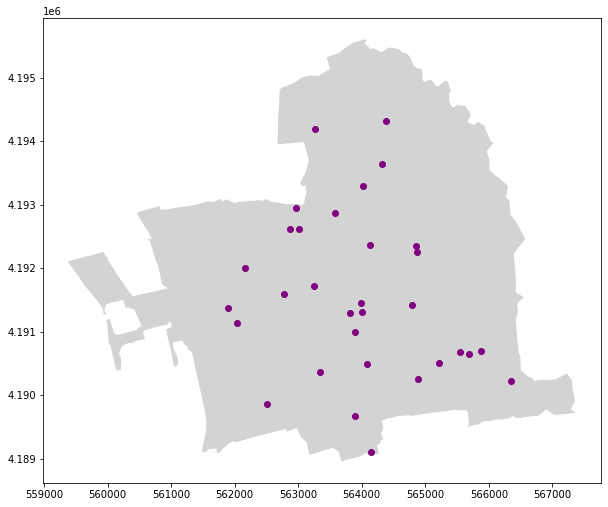

In [242]:
fig, ax = plt.subplots(figsize=(10,10))
berkeley_utm10.plot(color='lightgrey', ax=ax)
schools_gdf_utm10[berkeley_schools].plot(color='purple',ax=ax)

# 6.3 Proximity Analysis

Now that we've seen the basic idea of spatial measurement and relationship queries,
let's take a look at a common analysis that combines those concepts: **promximity analysis**.

Proximity analysis seeks to identify all features in a focal feature set
that are within some maximum distance of features in a reference feature set.

A common workflow for this analysis is:

1. Buffer (i.e. add a margin around) the reference dataset, out to the maximum distance.
1. Run a spatial relationship query to find all focal features that intersect (or are within) the buffer.

---------------------------------

Let's read in the bike boulevard data again.

Then we'll find all Berkeley schools that are within a block's distance (200 m) of the boulevards.

<AxesSubplot:>

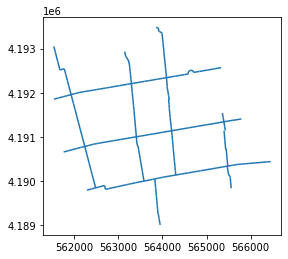

In [235]:
bike_blvds = gpd.read_file('notebook_data/transportation/BerkeleyBikeBlvds.geojson')
bike_blvds.plot()

Of course, we need to reproject the boulevards to our projected CRS.

In [236]:
bike_blvds_utm10 = bike_blvds.to_crs( "epsg:26910")

/usr/lib/python3.8/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


Now we can create our 200 meter bike boulevard buffers.

In [288]:
bike_blvds_buf = bike_blvds_utm10.buffer(distance=200)

Now let's overlay everything.

<AxesSubplot:>

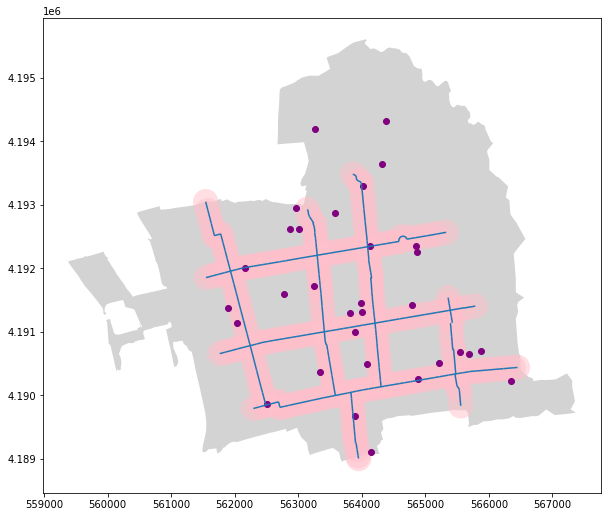

In [289]:
fig, ax = plt.subplots(figsize=(10,10))
berkeley_utm10.plot(color='lightgrey', ax=ax)
bike_blvds_buf.plot(color='pink', ax=ax, alpha=0.5)
bike_blvds_utm10.plot(ax=ax)
berkeley_schools.plot(color='purple',ax=ax)

Great! Looks like we're all ready to run our intersection to complete the proximity analysis.


**NOTE**: In order to subset with our buffers we need to call the `unary_union` attribute of the buffer object.
This gives us a single unified polygon, rather than a series of multipolygons representing buffers around each of the points in our multilines.

In [290]:
schools_near_blvds = berkeley_schools.within(bike_blvds_buf.unary_union)

Now let's overlay again, to see if the schools we subsetted make sense.

<AxesSubplot:>

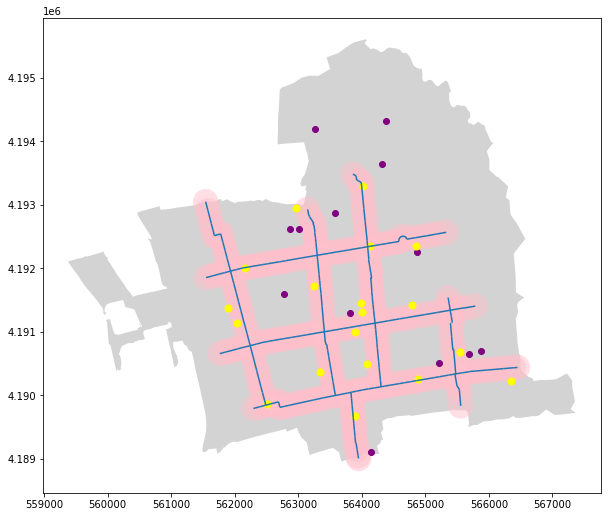

In [305]:
fig, ax = plt.subplots(figsize=(10,10))
berkeley_utm10.plot(color='lightgrey', ax=ax)
bike_blvds_buf.plot(color='pink', ax=ax, alpha=0.5)
bike_blvds_utm10.plot(ax=ax)
berkeley_schools.plot(color='purple',ax=ax)
berkeley_schools[schools_near_blvds].plot(color='yellow', markersize=50, ax=ax)

# TODO <font color='red'> CONSIDER WHETHER TO KEEP OR MOVE THIS AFTER DECIDING ABOUT DISTANCE STUFF </font>

In [123]:
def min_distance(point, lines):
    return lines.distance(point).min()

schools_gdf_utm10[schools_within_berkeley].geometry.apply(min_distance, args=(bike_blvds_utm10,))

26      13.848161
27     985.459488
28     309.889446
29     369.402946
30     196.011379
31      15.332395
32      27.250406
33     439.758905
34     107.902846
35     926.216792
36     193.030072
37     181.836256
38     373.736477
39     215.903128
40     184.321307
41     186.446907
406      1.288383
431     94.064527
432    211.477566
433    218.613628
434    186.913116
435    230.212129
436     15.162313
437    188.829602
438    232.764113
439    224.700672
440    173.920971
441     15.892361
442    514.765384
443     92.556921
444     93.426741
516    128.131187
Name: geometry, dtype: float64

## 6.4 Exercise

What schools are near BART stations?

In [113]:
bart_stations = gpd.read_file('notebook_data/transportation/bart.csv')
bart_stations_gdf = gpd.GeoDataFrame(bart_stations, 
                               geometry=gpd.points_from_xy(bart_stations.lon, bart_stations.lat))
bart_stations_gdf.crs = "epsg:4326"

bart_stations_gdf_utm10 = bart_stations_gdf.to_crs( "epsg:26910")

In [114]:
bart_stations_utm10 = bart_stations.to_crs( "epsg:26910")

In [116]:
bart_buf = bart_stations_utm10.buffer(distance=500)

(4188960.932425667, 4195616.510453224)

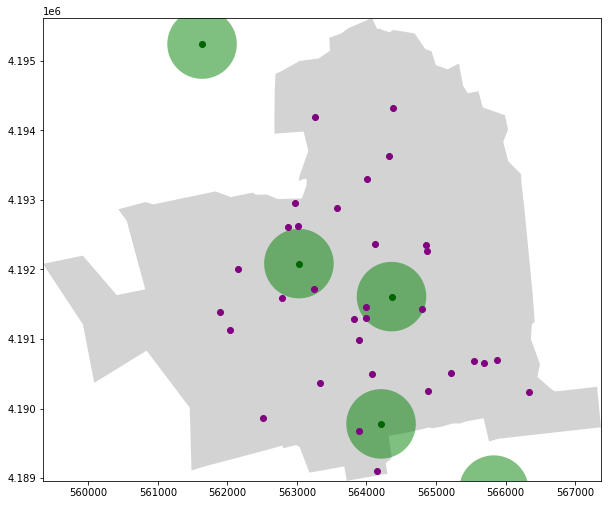

In [119]:
fig, ax = plt.subplots(figsize=(10,10))
berkeley_places_utm10.plot(color='lightgrey', ax=ax)
bart_buf.plot(color='green',ax=ax,alpha=.5)
schools_gdf_utm10[schools_within_berkeley].plot(color='purple',ax=ax)
bart_stations_utm10.plot(color='darkgreen',ax=ax)

minx, miny, maxx, maxy = berkeley_places_utm10.total_bounds
plt.xlim(minx, maxx)
plt.ylim(miny, maxy)

---
<div style="display:inline-block;vertical-align:middle;">
<a href="https://dlab.berkeley.edu/" target="_blank"><img src ="../assets/images/dlab_logo.png" width="75" align="left">
</a>
</div>

<div style="display:inline-block;vertical-align:middle;">
    <div style="font-size:larger">&nbsp;D-Lab @ University of California - Berkeley</div>
    <div>&nbsp;Team Geo<div>
</div>
        


